In [1]:
import numpy as np
import pandas as pd

from apyori import apriori
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.font_manager import FontProperties

from datetime import datetime
import en_nlp_utils

In [2]:
# Define default source path
SRC_PATH = "src/"

start_time = datetime.now()
print("Text processing started at {}".format(start_time))

Text processing started at 2024-06-29 16:43:44.863244


In [3]:
# Load dataset
df_review = pd.read_csv(SRC_PATH + "en_hotel_review.csv")

# Check NULL values
en_nlp_utils.check_null(df_review, "df_review")

df_review:
source                       0
hotel_id                     0
hotel_name                   0
country                      0
group_name                   0
room_type                    0
stay_length                  0
stay_date                    0
review_score                 0
review_score_category        0
sentiment                    0
review_date                  0
review_title                 1
review                       0
review_cleaned_v1            0
review_cleaned_v2            0
review_cleaned_v3            0
ADJ                       7273
ADV                      20030
NOUN                      4629
VERB                     15465
PROPN                    23049
DET                      36543
NUM                      36554
dtype: int64
Total rows in df_review: 37967 



## 1) Association Rule Mining

### a) Helper functions

In [4]:
# Function to convert the input value of a string type to a list of words
def process_all_words(value):
    if isinstance(value, str):
        return value.split()
    return []


# Function to discover association rules between item sets in a data set
# and to represent these rules as a graphical network for visualization
def find_association_rules(target_text, min_support=0.01, min_confidence=0.3, min_lift=3, min_length=2):
    
    # Process target_text: split each string into a list of words
    text = target_text.apply(process_all_words)
    text = [x for x in text if x != []]  # Remove empty lists
    
    # Find association rules using Apriori algorithm
    association_rules = apriori(text, min_support=min_support, min_confidence=min_confidence, 
                                min_lift=min_lift, min_length=min_length)
    association_results = list(association_rules)
    
    # Initialize a directed graph
    G = nx.DiGraph()
    
    # Summarize association rules and add edges to the graph
    rules_summary = [{
        "antecedent": list(item[2][0][0]),
        "consequent": list(item[2][0][1]),
        "support": round(item[1], 4),
        "confidence": round(item[2][0][2], 4),
        "lift": round(item[2][0][3], 4),
    } for item in association_results]
    
    print(f"Success. {len(rules_summary)} rules found.")
    print("========================================")
    
    # Print and add edges to the graph
    for rule in rules_summary:
        print(f"Rule: {rule['antecedent']} => {rule['consequent']}")
        print("Support: " + str(rule["support"]))
        print("Confidence: " + str(rule["confidence"]))
        print("Lift: " + str(rule["lift"]))
        print("----------------------------------------")
        
        # Add edges to the graph
        for ant in rule["antecedent"]:
            for con in rule["consequent"]:
                G.add_edge(ant, con, weight=rule["lift"], support=rule["support"], confidence=rule["confidence"])

    # Check if there are any edges to plot
    edges = G.edges(data=True)
    if not edges:
        print("No edges to plot. Exiting visualization.")
        return
    
    # Create a custom colormap
    colors = plt.cm.Blues(np.linspace(0.5, 1, 256))
    new_cmap = LinearSegmentedColormap.from_list("new_blues", colors)
    
    # Draw the network graph
    pos = nx.spring_layout(G, k=1, iterations=15)  # Adjust layout parameters for a more compact graph
    plt.figure(figsize=(12, 12))  # Increase figure size for better visibility
    
    # Node color and size
    node_color = "skyblue"
    node_size = 3000
    
    # Edge width and color
    edge_color = [d["weight"] for (u, v, d) in edges]
    
    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
    
    # Function to shorten edges to prevent overlap with nodes
    def shorten_edge(pos, src, dst, shrink_factor=0.1):
        """Shorten edges to prevent overlap with nodes"""
        x1, y1 = pos[src]
        x2, y2 = pos[dst]
        new_x2 = x1 + (x2 - x1) * (1 - shrink_factor)
        new_y2 = y1 + (y2 - y1) * (1 - shrink_factor)
        return (x1, y1), (new_x2, new_y2)
    
    new_edges = []
    for src, dst, data in edges:
        new_edges.append((*shorten_edge(pos, src, dst), data))
    
    # Draw edges with shortened positions
    for ((x1, y1), (x2, y2), data) in new_edges:
        plt.arrow(x1, y1, x2 - x1, y2 - y1, color=new_cmap(Normalize(vmin=min(edge_color), 
                                                                     vmax=max(edge_color))(data["weight"])),
            alpha=0.8, head_width=0.05, head_length=0.1, length_includes_head=True, width=0.01)
        # Show lift value at the midpoint of the edge
        plt.text((x1 + x2) / 2, (y1 + y2) / 2, f"{data['weight']:.2f}", fontsize=10, 
                 horizontalalignment="center", verticalalignment="center")

    # Draw labels with specified font
    for node, (x, y) in pos.items():
        plt.text(x, y, node, fontsize=12, horizontalalignment="center", verticalalignment="center")
    
    # Adjust color mapping for better visibility of the lightest color
    norm = Normalize(vmin=min(edge_color), vmax=max(edge_color))
    sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=plt.gca())
    
    plt.title("Association Rules Network")
    plt.show()

### b) Find association using whole cleaned reviews

Length of df_review: 37967
Length of df_target_text: 37967
Success. 22 rules found.
Rule: ['access'] => ['easy']
Support: 0.0127
Confidence: 0.5095
Lift: 12.7683
----------------------------------------
Rule: ['bottle'] => ['water']
Support: 0.0114
Confidence: 0.8745
Lift: 14.7172
----------------------------------------
Rule: ['buffet'] => ['breakfast']
Support: 0.0114
Confidence: 0.834
Lift: 9.8518
----------------------------------------
Rule: ['bus'] => ['station']
Support: 0.0248
Confidence: 0.4459
Lift: 5.1958
----------------------------------------
Rule: ['bus'] => ['stop']
Support: 0.0292
Confidence: 0.5234
Lift: 14.3274
----------------------------------------
Rule: ['bus'] => ['walk']
Support: 0.0181
Confidence: 0.3243
Lift: 3.3999
----------------------------------------
Rule: ['desk'] => ['front']
Support: 0.0192
Confidence: 0.7717
Lift: 21.2151
----------------------------------------
Rule: ['distance'] => ['walk']
Support: 0.0344
Confidence: 0.8982
Lift: 9.4154
---------

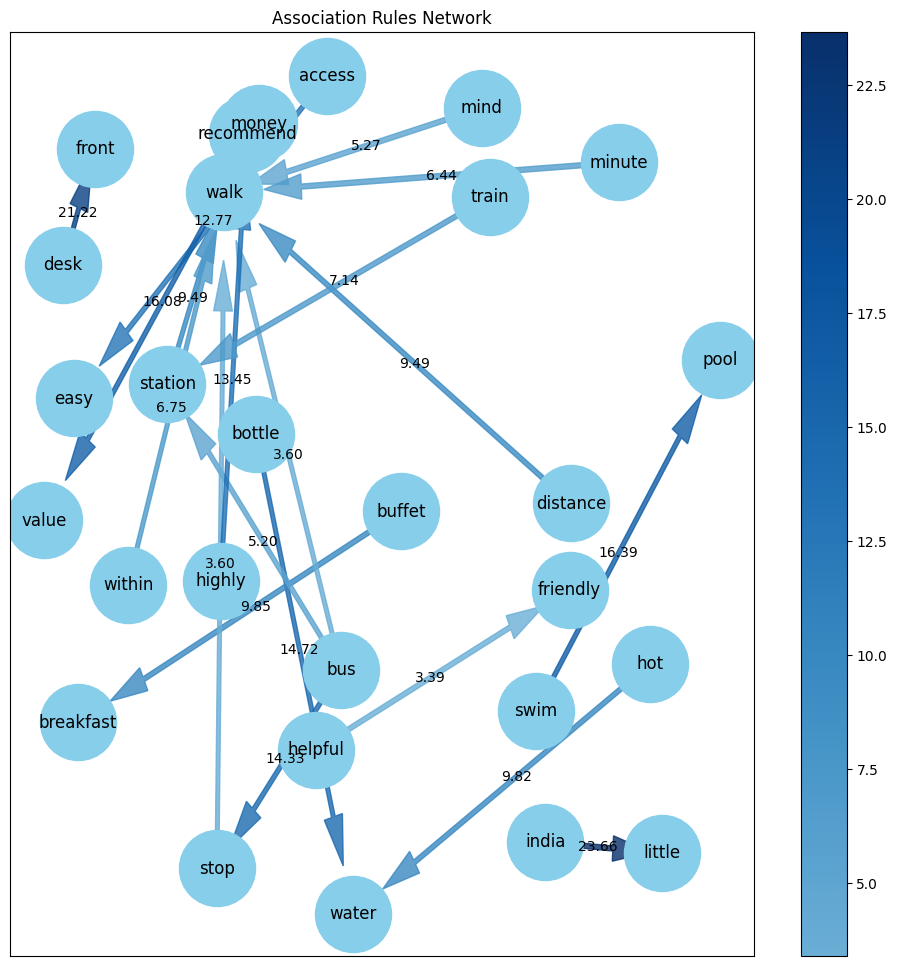

In [5]:
target_text = "review_cleaned_v3"

# Remove rows when target_text is NULL
df_target_text = df_review.dropna(subset=[target_text]).reset_index(drop=True)
print(f"Length of df_review: {len(df_review)}")
print(f"Length of df_target_text: {len(df_target_text)}")

# Find association
find_association_rules(df_target_text[target_text])

### c) Find association using words by POS tagging

Length of ADJ: 30694
Success. 13 rules found.
Rule: ['sleeper'] => ['light']
Support: 0.0007
Confidence: 0.5128
Lift: 54.4654
----------------------------------------
Rule: ['proof'] => ['sound']
Support: 0.0007
Confidence: 0.6667
Lift: 119.6647
----------------------------------------
Rule: ['cold', 'available'] => ['hot']
Support: 0.0006
Confidence: 0.6129
Lift: 23.9344
----------------------------------------
Rule: ['free', 'cold'] => ['hot']
Support: 0.0005
Confidence: 0.5161
Lift: 20.1553
----------------------------------------
Rule: ['spacious', 'cold'] => ['hot']
Support: 0.0007
Confidence: 0.5263
Lift: 20.5531
----------------------------------------
Rule: ['public', 'excellent'] => ['easy']
Support: 0.0006
Confidence: 0.5152
Lift: 12.3628
----------------------------------------
Rule: ['easy', 'convenient', 'great'] => ['overall']
Support: 0.0005
Confidence: 0.6154
Lift: 11.4755
----------------------------------------
Rule: ['public', 'great', 'friendly'] => ['easy']
Support

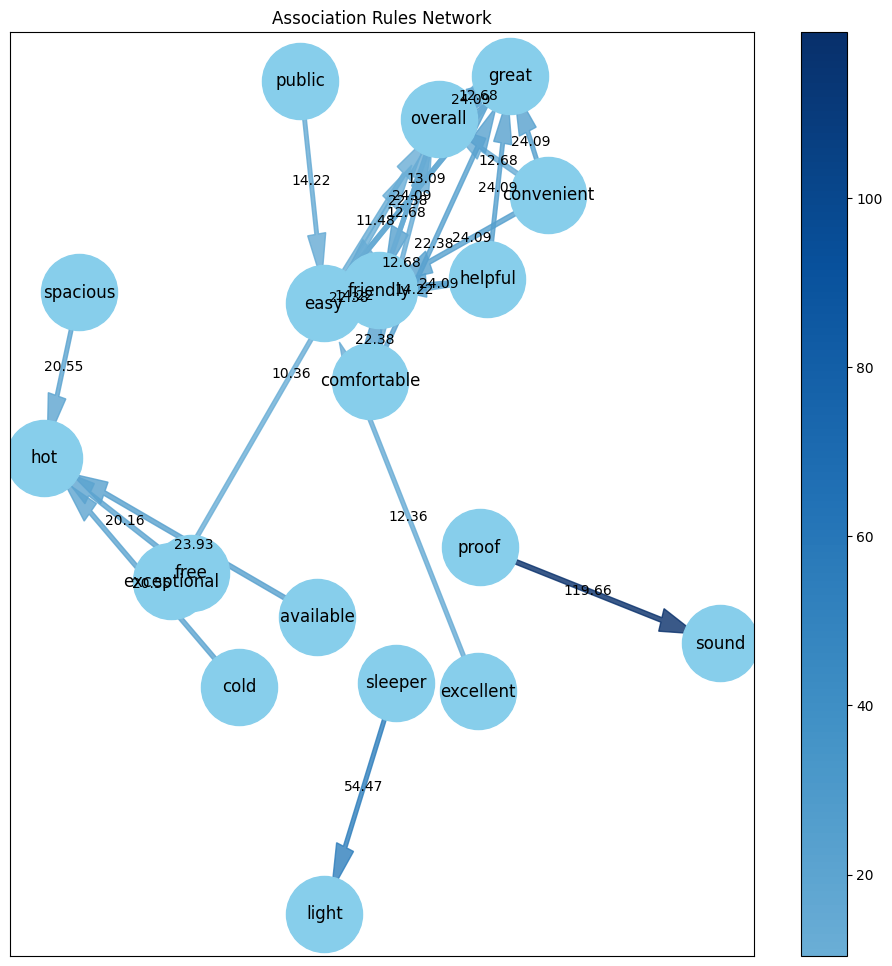

In [6]:
# Remove rows when "ADJ" is NULL
df_tag = df_review.dropna(subset=["ADJ"]).reset_index(drop=True)
print(f"Length of ADJ: {len(df_tag)}")

# Find association
find_association_rules(df_tag["ADJ"], 0.0005, 0.5, 10)

Length of ADV: 17937
Success. 2 rules found.
Rule: ['somewhere'] => ['else']
Support: 0.0023
Confidence: 0.4516
Lift: 28.4231
----------------------------------------
Rule: ['away', 'much'] => ['pretty']
Support: 0.0005
Confidence: 0.4286
Lift: 15.8828
----------------------------------------


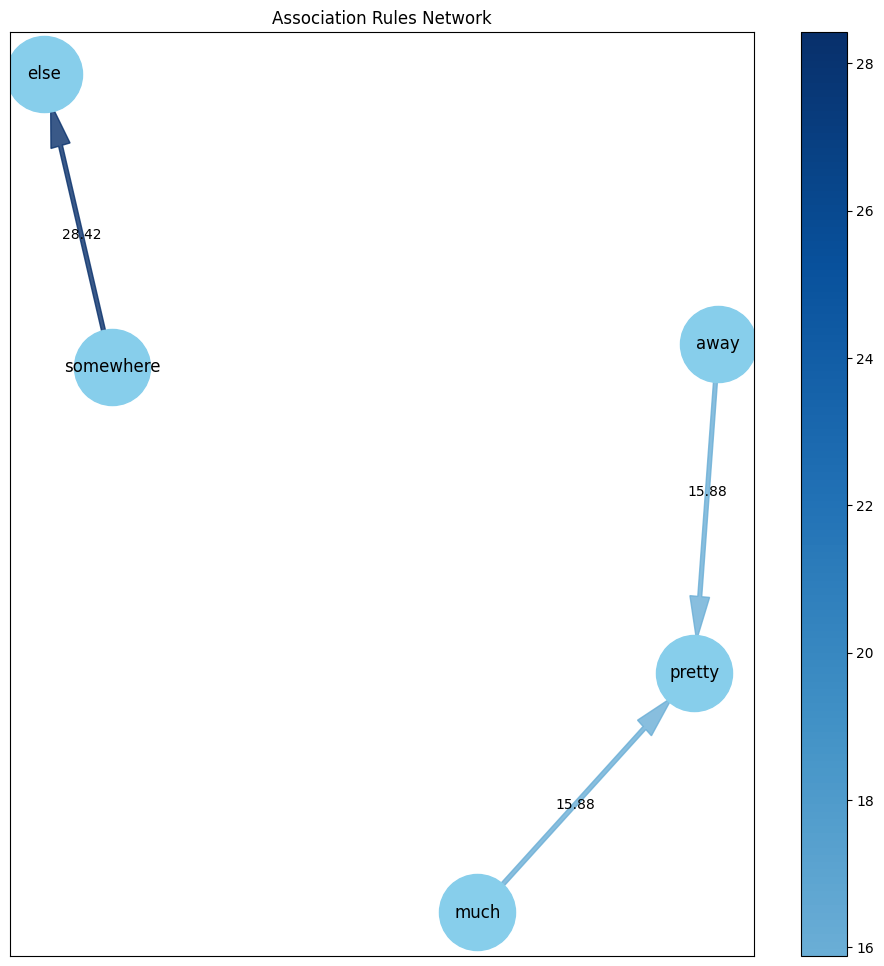

In [7]:
# Remove rows when "ADV" is NULL
df_tag = df_review.dropna(subset=["ADV"]).reset_index(drop=True)
print(f"Length of ADV: {len(df_tag)}")

# Find association
find_association_rules(df_tag["ADV"], 0.0005, 0.3, 10)

Length of NOUN: 33338
Success. 23 rules found.
Rule: ['alarm'] => ['fire']
Support: 0.0011
Confidence: 0.6102
Lift: 207.5697
----------------------------------------
Rule: ['basal'] => ['brass']
Support: 0.0014
Confidence: 0.8727
Lift: 528.9997
----------------------------------------
Rule: ['tub'] => ['bath']
Support: 0.0014
Confidence: 0.7581
Lift: 61.0443
----------------------------------------
Rule: ['credit'] => ['card']
Support: 0.0018
Confidence: 0.6778
Lift: 69.5254
----------------------------------------
Rule: ['clark'] => ['quay']
Support: 0.0011
Confidence: 0.6667
Lift: 134.699
----------------------------------------
Rule: ['droop'] => ['sound']
Support: 0.0011
Confidence: 0.7708
Lift: 89.8533
----------------------------------------
Rule: ['farmer'] => ['park']
Support: 0.0022
Confidence: 0.6952
Lift: 68.1701
----------------------------------------
Rule: ['bathroom', 'condition'] => ['air']
Support: 0.0014
Confidence: 0.6301
Lift: 36.8553
-------------------------------

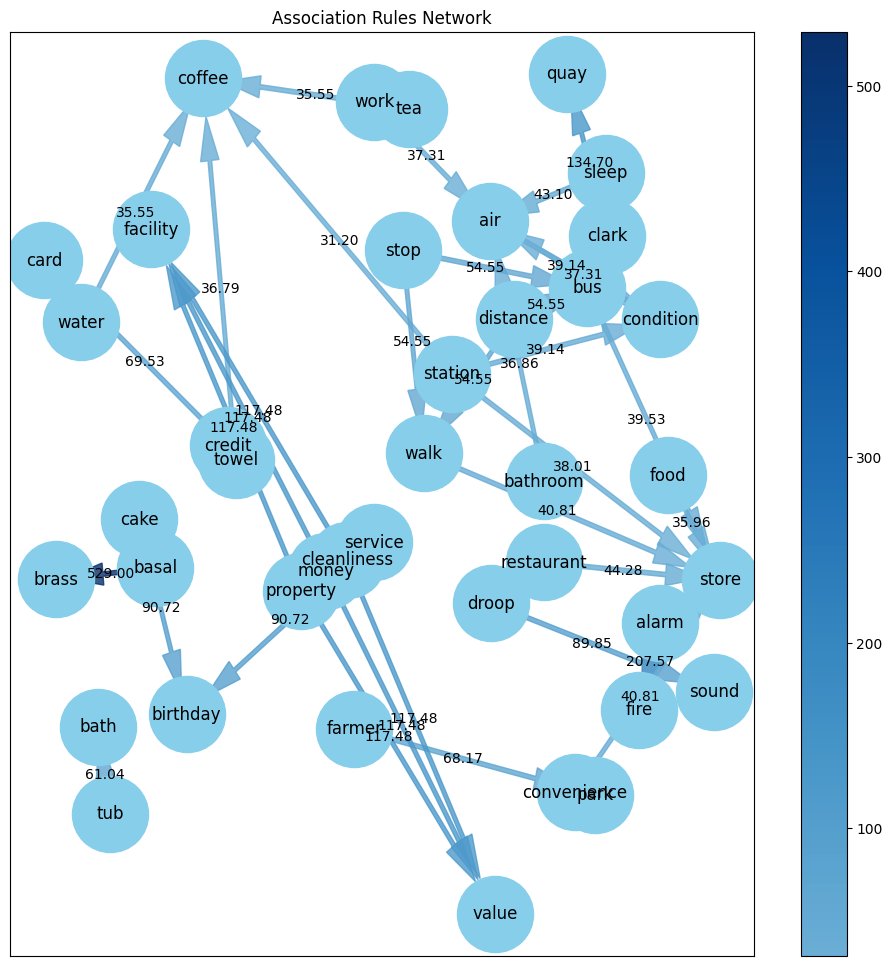

In [8]:
# Remove rows when "NOUN" is NULL
df_tag = df_review.dropna(subset=["NOUN"]).reset_index(drop=True)
print(f"Length of NOUN: {len(df_tag)}")

# Find association
find_association_rules(df_tag["NOUN"], 0.001, 0.6, 30)

Length of VERB: 22502
Success. 6 rules found.
Rule: ['talk'] => ['hear']
Support: 0.0025
Confidence: 0.5045
Lift: 17.6006
----------------------------------------
Rule: ['insist'] => ['tell']
Support: 0.0006
Confidence: 0.3023
Lift: 13.7711
----------------------------------------
Rule: ['call', 'tell'] => ['wait']
Support: 0.0006
Confidence: 0.4483
Lift: 20.4607
----------------------------------------
Rule: ['want', 'let'] => ['know']
Support: 0.0005
Confidence: 0.3429
Lift: 16.9933
----------------------------------------
Rule: ['send', 'tell'] => ['wait']
Support: 0.0006
Confidence: 0.3889
Lift: 17.7501
----------------------------------------
Rule: ['send', 'want'] => ['tell']
Support: 0.0006
Confidence: 0.3514
Lift: 16.0043
----------------------------------------


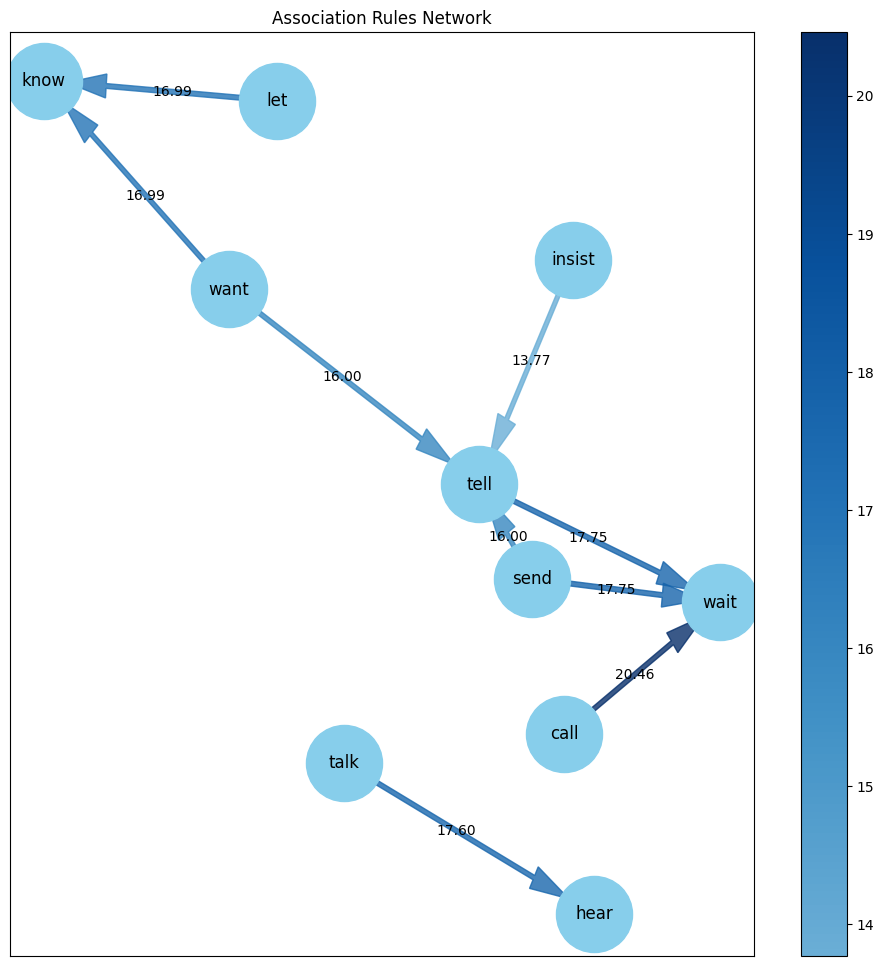

In [9]:
# Remove rows when "VERB" is NULL
df_tag = df_review.dropna(subset=["VERB"]).reset_index(drop=True)
print(f"Length of VERB: {len(df_tag)}")

# Find association
find_association_rules(df_tag["VERB"], 0.0005, 0.3, 10)

Length of PROPN: 14918
Success. 20 rules found.
Rule: ['bay'] => ['marina']
Support: 0.0173
Confidence: 0.8012
Lift: 37.006
----------------------------------------
Rule: ['sand'] => ['bay']
Support: 0.0038
Confidence: 0.9828
Lift: 45.5304
----------------------------------------
Rule: ['junction'] => ['boris']
Support: 0.0058
Confidence: 0.9775
Lift: 26.6109
----------------------------------------
Rule: ['buena'] => ['vista']
Support: 0.0012
Confidence: 1.0
Lift: 532.7857
----------------------------------------
Rule: ['rustle'] => ['bustle']
Support: 0.0011
Confidence: 0.85
Lift: 333.6921
----------------------------------------
Rule: ['town'] => ['china']
Support: 0.0057
Confidence: 0.9551
Lift: 79.1529
----------------------------------------
Rule: ['clarke'] => ['quay']
Support: 0.0057
Confidence: 0.8763
Lift: 61.3731
----------------------------------------
Rule: ['little'] => ['india']
Support: 0.001
Confidence: 0.9375
Lift: 35.0517
----------------------------------------
Rule

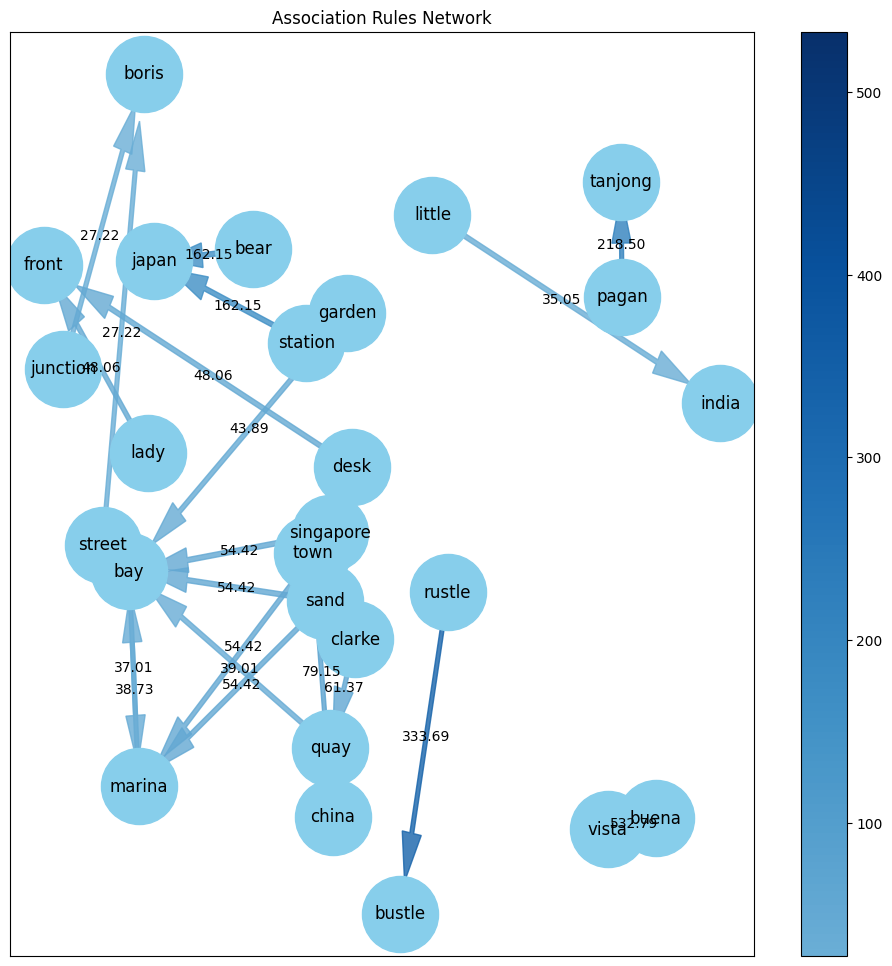

In [10]:
# Remove rows when "PROPN" is NULL
df_tag = df_review.dropna(subset=["PROPN"]).reset_index(drop=True)
print(f"Length of PROPN: {len(df_tag)}")

# Find association
find_association_rules(df_tag["PROPN"], 0.001, 0.8, 20)

Length of DET: 1424
Success. 11 rules found.
Rule: ['bugnothe'] => ['half']
Support: 0.0007
Confidence: 1.0
Lift: 356.0
----------------------------------------
Rule: ['bunkthe'] => ['flodedthe']
Support: 0.0007
Confidence: 1.0
Lift: 1424.0
----------------------------------------
Rule: ['bunkthe'] => ['muchthe']
Support: 0.0007
Confidence: 1.0
Lift: 1424.0
----------------------------------------
Rule: ['familiesthe'] => ['singaporethe']
Support: 0.0007
Confidence: 1.0
Lift: 474.6667
----------------------------------------
Rule: ['flodedthe'] => ['muchthe']
Support: 0.0007
Confidence: 1.0
Lift: 1424.0
----------------------------------------
Rule: ['guestwelthis'] => ['hehethat']
Support: 0.0007
Confidence: 1.0
Lift: 1424.0
----------------------------------------
Rule: ['bunkthe'] => ['flodedthe', 'every']
Support: 0.0007
Confidence: 1.0
Lift: 1424.0
----------------------------------------
Rule: ['bunkthe'] => ['every', 'muchthe']
Support: 0.0007
Confidence: 1.0
Lift: 1424.0
------

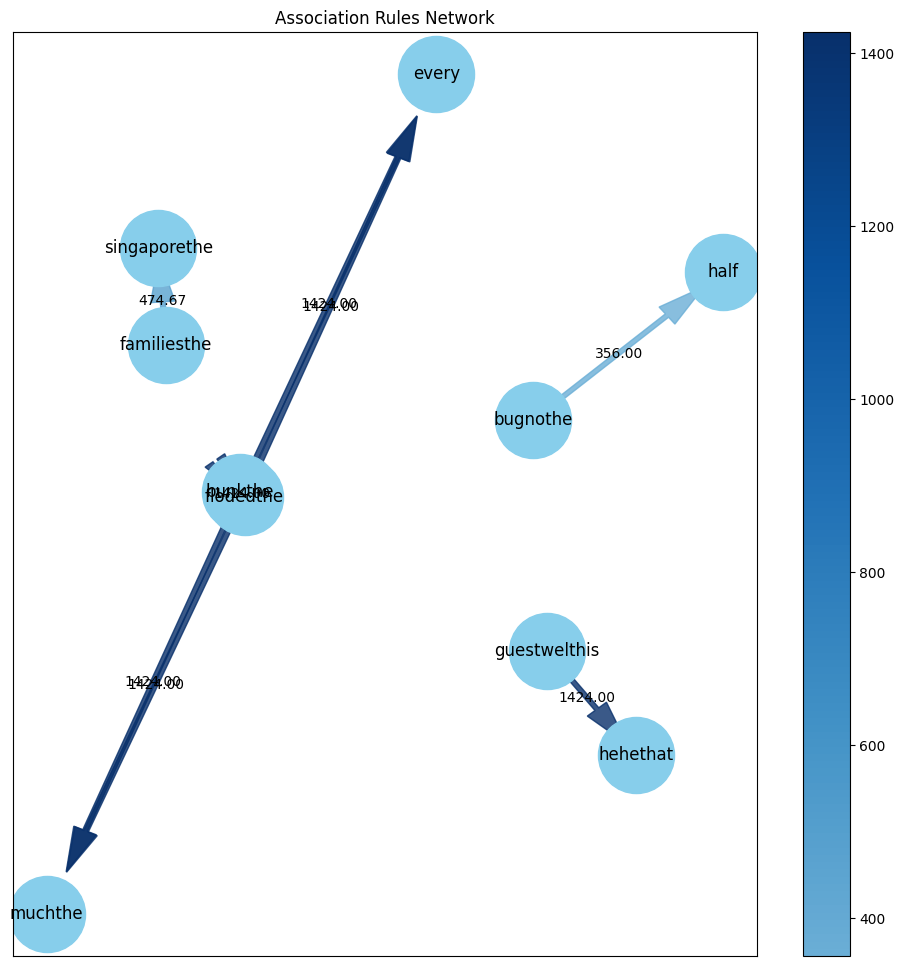

In [11]:
# Remove rows when "DET" is NULL
df_tag = df_review.dropna(subset=["DET"]).reset_index(drop=True)
print(f"Length of DET: {len(df_tag)}")

# Find association
find_association_rules(df_tag["DET"], 0.0005, 0.3, 20)

Length of NUM: 1413
Success. 4 rules found.
Rule: ['eight'] => ['two', 'three']
Support: 0.0007
Confidence: 1.0
Lift: 47.1
----------------------------------------
Rule: ['two', 'seven'] => ['eleven']
Support: 0.0007
Confidence: 1.0
Lift: 10.9535
----------------------------------------
Rule: ['two', 'ten'] => ['four']
Support: 0.0014
Confidence: 1.0
Lift: 13.7184
----------------------------------------
Rule: ['five', 'six'] => ['two', 'three']
Support: 0.0007
Confidence: 1.0
Lift: 47.1
----------------------------------------


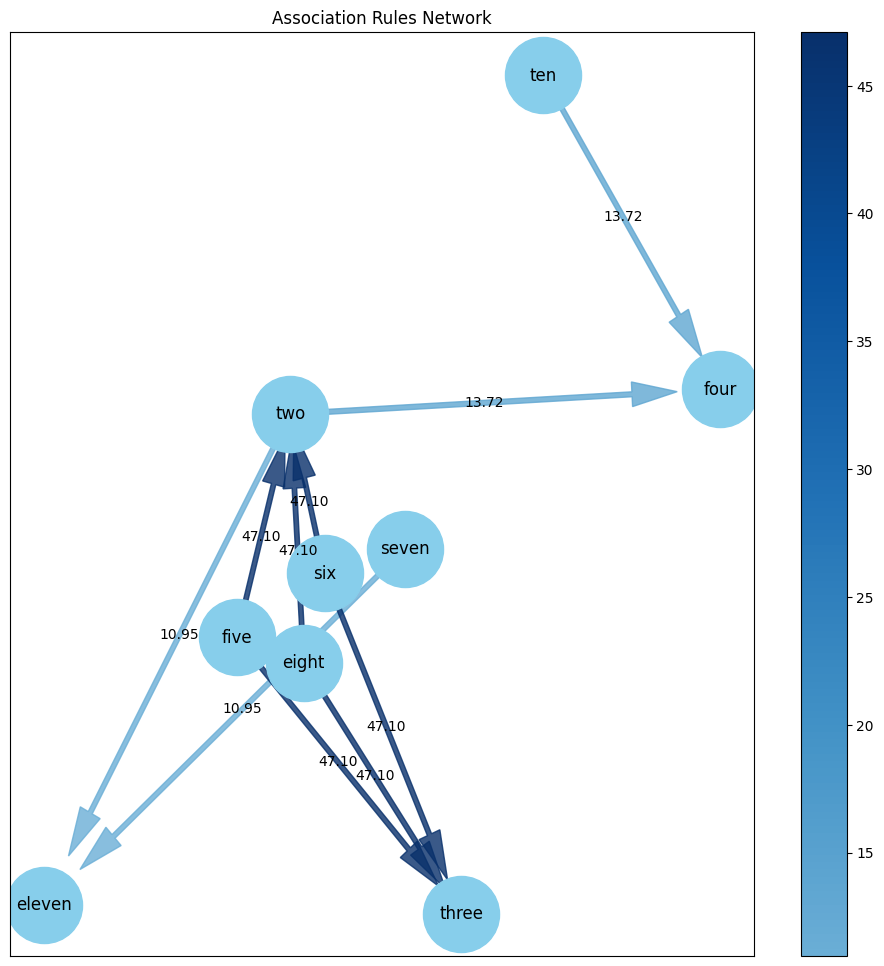

In [12]:
# Remove rows when "NUM" is NULL
df_tag = df_review.dropna(subset=["NUM"]).reset_index(drop=True)
print(f"Length of NUM: {len(df_tag)}")

# Find association
find_association_rules(df_tag["NUM"], 0.0005, 0.3, 10)

In [13]:
end_time = datetime.now()
print("Text processing ended at {}".format(end_time))
print("Text processing spent {}".format(end_time - start_time))

Text processing ended at 2024-06-29 16:44:11.142315
Text processing spent 0:00:26.279071
